# Load data & Setup

## Imports

In [3]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import math

# own modules
import eda_methods as eda

# visualization
import seaborn as sns
sns.set(style="white")  
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from pandas.plotting import scatter_matrix

# warnings handler
import warnings
warnings.filterwarnings("ignore")

# Machine Learning Libraries
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer

#Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer

# Imbalanced Learn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# random state
random_state = 100

# Variables for plot sizes
matplotlib.rc('font', size=16)          # controls default text sizes
matplotlib.rc('axes', titlesize=14)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=14)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=14)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=14)    # legend fontsize
matplotlib.rc('figure', titlesize=20)

## Load Dataframe

In [3]:
# new feature dataframe
df_importance = pd.read_csv('data/df_clean_engineered_all.csv')

y = df_importance['churn']
df_importance = df_importance.drop(['churn','plz_3','abo_registrierung_min','nl_registrierung_min','ort'], axis = 1)

df_importance = pd.get_dummies(df_importance, columns = ['kanal', 'objekt_name', 'aboform_name', 'zahlung_rhythmus_name','zahlung_weg_name', 'plz_1', 'plz_2', 'land_iso_code', 'anrede','titel'], drop_first = True)

In [4]:
df_importance.head(5)

,liefer_beginn_evt,lesedauer,rechnungsmonat,studentenabo,metropole,shop_kauf,unterbrechung,email_am_kunden,zon_che_opt_in,zon_sit_opt_in,...,plz_2_99,plz_2_xx,land_iso_code_CH,land_iso_code_DE,land_iso_code_andere,anrede_Frau,anrede_Herr,anrede_unbekannt,titel_kein Titel,titel_sonstiger Titel
0,2013.833333,68,0,0,0,4,0,1.0,0,0,...,0,0,0,1,0,1,0,0,0,0
1,2013.833333,68,0,0,0,4,0,1.0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,2013.833333,68,0,0,0,4,0,1.0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,2013.833333,72,0,0,0,0,0,1.0,0,0,...,0,0,0,1,0,0,1,0,1,0
4,2013.750000,70,0,0,0,0,0,1.0,0,0,...,0,1,0,0,1,1,0,0,1,0


## Results Dictionary

In [9]:
def train_predict(modelname, y_train, y_test, predictions_train, predictions_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - 
       - y_train: income training set
       -
       - y_test: income testing set
    '''
    
    results = {}
    
    # model name 
    results['model'] = modelname
    
    # accuracy
    results['acc_train'] = accuracy_score(y_train,predictions_train)
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # F-score
    #results['f_train'] = fbeta_score(y_train,predictions_train,0.5)
    #results['f_test'] = fbeta_score(y_test,predictions_test,0.5) 
    
    # F1-score
    results['f1_train'] = f1_score(y_train,predictions_train)
    results['f1_test'] = f1_score(y_test,predictions_test) 
    
    # Recall
    results['recall_train'] = recall_score(y_train,predictions_train)
    results['recall_test'] = recall_score(y_test,predictions_test) 
    
    # Precision
    results['precision_train'] = precision_score(y_train,predictions_train)
    results['precision_test'] = precision_score(y_test,predictions_test) 
    
    # Return the results
    return results

## Pipeline Setup

In [16]:
def pipeline(X,y,balance=None):
    
    # devide features
    categoric_features = list(X.columns[X.dtypes==object])

    numeric_features = list(X.columns[X.dtypes != object])

    # split train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state,stratify=y)
    
    if balance == 'over':
        # define oversampling strategy
        print('Oversampling')
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_train, y_train = oversample.fit_resample(X_train, y_train)

    if balance == 'under':
        print('Undersampling')
        # define undersample strategy
        undersample = RandomUnderSampler(sampling_strategy='majority')
        X_train, y_train = undersample.fit_resample(X_train, y_train)
       
    models={
        #'KNN' : KNeighborsClassifier(n_neighbors=5, metric='euclidean',n_jobs=-1),
        #'SVC' : LinearSVC(),
        #'logreg': LogisticRegression(random_state=random_state,n_jobs=-1), 
        #'decisiontree': DecisionTreeClassifier(random_state=random_state,max_depth=10),
        'randomforest': RandomForestClassifier(random_state=random_state, n_jobs=-1,n_estimators=500),
        #'randomforest':  RandomForestClassifier(n_jobs=-1,n_estimators=200, criterion='entropy',min_samples_split=2, min_samples_leaf=2, max_features='auto', max_depth=85,bootstrap=True,random_state=random_state),
        #'XGBoost' : XGBClassifier(random_state=random_state, n_jobs=-1),
        #'adaBoost' : AdaBoostClassifier(random_state=random_state)
        }  
    
    # create preprocessors
    numeric_transformer = Pipeline(steps=[
        ('imputer_num', SimpleImputer(strategy='median')),
        #('scaler', MinMaxScaler())
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
            ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categoric_features)
        ])

    model_results = pd.DataFrame(columns=['model','acc_train','acc_test','f1_train','f1_test','recall_train','recall_test','precision_train','precision_test'])
    
    # process pipeline for every model
    for model in models.items():
        
        print(model[0])
        pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                               (model[0], model[1])
                               ])

        # fit model
        pipe.fit(X_train, y_train)

        #predict results
        #y_train_pred = cross_val_predict(pipe, X_train, y_train, cv=5, n_jobs=-1)
        y_train_pred = pipe.predict(X_train)
        y_test_pred = pipe.predict(X_test)
        
        results = train_predict(model[0],y_train, y_test, y_train_pred, y_test_pred)
        
        model_results = pd.concat([model_results, pd.DataFrame(results,index=[0])])
                                                
        conf_mat = pd.crosstab(np.ravel(y_test), np.ravel(y_test_pred),
                               colnames=["Predicted"], rownames=["Actual"])
        sns.heatmap(conf_mat, annot=True, cmap="Blues",fmt='d')
        plt.show()
        plt.close()
                                                
        # print results
        #print("\nResults on training data: ")
        #print(classification_report(y_train, y_train_pred))
        #print("\nResults on test data:")
        #print(classification_report(y_test, y_test_pred))
        print("\nConfusion matrix on test")
        print(confusion_matrix(y_test, y_test_pred))
        print("\n")
    return model_results

# Optimization - Top21 Features

In [120]:
important_features_combined_dropping = ['zahlung_weg_name_Rechnung',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'objekt_name_DIE ZEIT - CHRIST & WELT',
 'clicked_anzahl_6m',
 'zahlung_rhythmus_name_halbjährlich',
 'studentenabo',
 'rechnungsmonat',
 'received_anzahl_bestandskunden_6m',
 'received_anzahl_bestandskunden_3m',
 'openrate_zeitbrief_3m',
 'objekt_name_ZEIT Digital',
 'nl_zeitshop',
 'nl_opt_in_sum',
 'cnt_umwandlungsstatus2_dkey',
 'anrede_Frau',
 'aboform_name_Negative Option',
 'MONTH_DELTA_nl_min',
 'MONTH_DELTA_abo_min']

In [121]:
df_importance = df_importance[important_features_combined_dropping]

In [122]:
df_importance.shape

(184660, 21)

In [123]:
X = df_importance

## All Models

In [124]:
feature_importance_combined_dropping = pipeline(X,y,balance='under')

Undersampling
logreg

Confusion matrix on test
[[21115 11055]
 [ 4515  9480]]


decisiontree

Confusion matrix on test
[[23053  9117]
 [ 5124  8871]]


randomforest

Confusion matrix on test
[[24511  7659]
 [ 3338 10657]]


XGBoost

Confusion matrix on test
[[22431  9739]
 [ 4506  9489]]


adaBoost

Confusion matrix on test
[[21330 10840]
 [ 4373  9622]]




In [290]:
feature_importance_combined_dropping.round(3)

,model,acc_train,acc_test,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test
0,logreg,0.667,0.663,0.671,0.549,0.680,0.677,0.663,0.462
0,decisiontree,0.671,0.692,0.661,0.555,0.642,0.634,0.681,0.493
0,randomforest,0.745,0.762,0.744,0.660,0.741,0.761,0.746,0.582
0,XGBoost,0.683,0.691,0.680,0.571,0.673,0.678,0.687,0.493
0,adaBoost,0.673,0.670,0.677,0.558,0.684,0.688,0.670,0.470


| model        |   acc_train |   acc_test |   f1_train |   f1_test |   recall_train |   recall_test |   precision_train |   precision_test |
|:-------------|------------:|-----------:|-----------:|----------:|---------------:|--------------:|------------------:|-----------------:|
| logreg       |        0.67 |       0.66 |       0.67 |      0.55 |           0.68 |          0.68 |              0.66 |             0.46 |
| decisiontree |        0.67 |       0.69 |       0.66 |      0.55 |           0.64 |          0.63 |              0.68 |             0.49 |
| randomforest |        0.74 |       0.76 |       0.74 |      0.66 |           0.74 |          0.76 |              0.75 |             0.58 |
| XGBoost      |        0.68 |       0.69 |       0.68 |      0.57 |           0.67 |          0.68 |              0.69 |             0.49 |
| adaBoost     |        0.67 |       0.67 |       0.68 |      0.56 |           0.68 |          0.69 |              0.67 |             0.47 |

In [129]:
feature_importance_combined_dropping.to_csv('ml_results/feature_importance_combined_dropping.csv')

In [149]:
feature_importance_combined_dropping_KNN = pipeline(X,y,balance='under')

Undersampling
KNN

Confusion matrix on test
[[20894 11276]
 [ 4536  9459]]


SVC

Confusion matrix on test
[[20955 11215]
 [ 4477  9518]]


logreg

Confusion matrix on test
[[21068 11102]
 [ 4497  9498]]


decisiontree

Confusion matrix on test
[[22534  9636]
 [ 4887  9108]]


randomforest

Confusion matrix on test
[[24354  7816]
 [ 3318 10677]]


XGBoost

Confusion matrix on test
[[22459  9711]
 [ 4563  9432]]


adaBoost

Confusion matrix on test
[[21262 10908]
 [ 4385  9610]]




In [291]:
feature_importance_combined_dropping_KNN.round(3)

,model,acc_train,acc_test,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test
0,KNN,0.656,0.657,0.660,0.545,0.669,0.676,0.652,0.456
0,SVC,0.668,0.660,0.674,0.548,0.685,0.680,0.662,0.459
0,logreg,0.668,0.662,0.673,0.549,0.682,0.679,0.664,0.461
0,decisiontree,0.675,0.685,0.664,0.556,0.643,0.651,0.687,0.486
0,randomforest,0.744,0.759,0.743,0.657,0.740,0.763,0.745,0.577
0,XGBoost,0.684,0.691,0.680,0.569,0.672,0.674,0.689,0.493
0,adaBoost,0.674,0.669,0.678,0.557,0.686,0.687,0.670,0.468


## Optimization of Random Forest

In [53]:
def pipeline_optimization(X,y,balance=None):
    
    # devide features
    categoric_features = list(X.columns[X.dtypes==object])

    numeric_features = list(X.columns[X.dtypes != object])

    # split train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state,stratify=y)
    
    if balance == 'over':
        # define oversampling strategy
        print('Oversampling')
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_train, y_train = oversample.fit_resample(X_train, y_train)

    if balance == 'under':
        print('Undersampling')
        # define undersample strategy
        undersample = RandomUnderSampler(sampling_strategy='majority')
        X_train, y_train = undersample.fit_resample(X_train, y_train)
        
    # Hyperparameter grid
    param_randomforest = {
    'randomforest__criterion': ['entropy','gini'], #np.linspace(10, 500,50).astype(int),
    'randomforest__n_estimators': [100, 200, 300, 400, 500, 1000], #np.linspace(10, 500,50).astype(int),
    'randomforest__max_depth': [None] + list(np.arange(5, 100, 5).astype(int)),
    'randomforest__max_features': ['auto', 'sqrt', None],
    'randomforest__bootstrap': [True, False],
    'randomforest__min_samples_leaf': [1, 2, 3],
    'randomforest__min_samples_split': [2, 3, 4],
    }
    
    models={
        #'KNN' : KNeighborsClassifier(n_neighbors=5, metric='euclidean',n_jobs=-1),
        #'SVC' : LinearSVC(),
        #'logreg': LogisticRegression(random_state=random_state,n_jobs=-1), 
        #'decisiontree': DecisionTreeClassifier(random_state=random_state,max_depth=10),
        'randomforest': RandomForestClassifier(random_state=random_state, n_jobs=-1)
        #'XGBoost' : XGBClassifier(random_state=random_state, n_jobs=-1),
        #'adaBoost' : AdaBoostClassifier(random_state=random_state)
        }  
    
    # create preprocessors
    numeric_transformer = Pipeline(steps=[
        ('imputer_num', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
        #('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
            ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categoric_features)
        ])

    model_results = pd.DataFrame(columns=['model','acc_train','acc_test','f1_train','f1_test','recall_train','recall_test','precision_train','precision_test'])
    
    # process pipeline for every model
    for model in models.items():
        
        print(model[0])
        pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                               (model[0], model[1])
                               ])

        grid_randomforest = RandomizedSearchCV(pipe, param_randomforest, cv=3, scoring='f1',
                           verbose=5, n_jobs=-1, n_iter = 100)
        # fit model
        grid_randomforest.fit(X_train, y_train)
        #pipe.fit(X_train, y_train)
        
        # Show best parameters
        print('Best score:\n{:.2f}'.format(grid_randomforest.best_score_))
        print("Best parameters:\n{}".format(grid_randomforest.best_params_))
        
        # Save best model as best_model
        best_model = grid_randomforest.best_estimator_
        
        #pipe_best = Pipeline(steps=[('preprocessor', preprocessor), 
        #                       (model[0], best_model)
        #                       ])
        
        # fit best pipe
        #pipe_best.fit(X_train, y_train)
        #predict results
        #y_train_pred = cross_val_predict(grid_randomforest,X_train,y_train,cv=5)
        y_train_pred = grid_randomforest.predict(X_train)
        #y_train_pred = cross_val_predict(pipe_best, X_train, y_train, cv=5)

        y_test_pred = grid_randomforest.predict(X_test)
        
        results = train_predict(model[0],y_train, y_test, y_train_pred, y_test_pred)
        
        model_results = pd.concat([model_results, pd.DataFrame(results,index=[0])])
        # print results
        #print("\nResults on training data: ")
        #print(classification_report(y_train, y_train_pred))
        #print("\nResults on test data:")
        #print(classification_report(y_test, y_test_pred))
        print("\nConfusion matrix on test")
        print(confusion_matrix(y_test, y_test_pred))
        print("\n")
    return model_results

### Optimization of RandomForest - Recall - RandomSearch

In [194]:
RandomizedSearch_randomforst = pipeline_optimization(X,y,balance='under')

Undersampling
randomforest
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 30.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 72.8min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 109.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 116.6min finished


Best score:
0.73
Best parameters:
{'randomforest__n_estimators': 500, 'randomforest__min_samples_split': 5, 'randomforest__min_samples_leaf': 1, 'randomforest__max_features': 'sqrt', 'randomforest__max_depth': None, 'randomforest__bootstrap': True}

Confusion matrix on test
[[24489  7681]
 [ 3260 10735]]




Best score:
0.73

Best parameters:
{'randomforest__n_estimators': 500, 'randomforest__min_samples_split': 5, 'randomforest__min_samples_leaf': 1, 'randomforest__max_features': 'sqrt', 'randomforest__max_depth': None, 'randomforest__bootstrap': True}

Confusion matrix on test

[[24489  7681]

 [ 3260 10735]]

In [196]:
RandomizedSearch_randomforst.round(3)

,model,acc_train,acc_test,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test
0,randomforest,0.989,0.763,0.989,0.662,0.99,0.767,0.987,0.583


In [310]:
conf_matrix = np.array([[24489,  7681],[ 3260, 10735]])

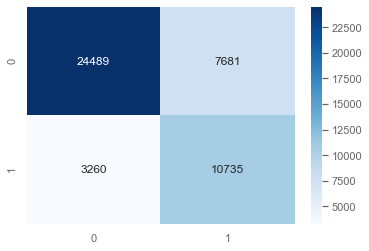

In [311]:
sns.heatmap(conf_matrix, annot=True, cmap="Blues",fmt='d')
plt.show()
plt.close()

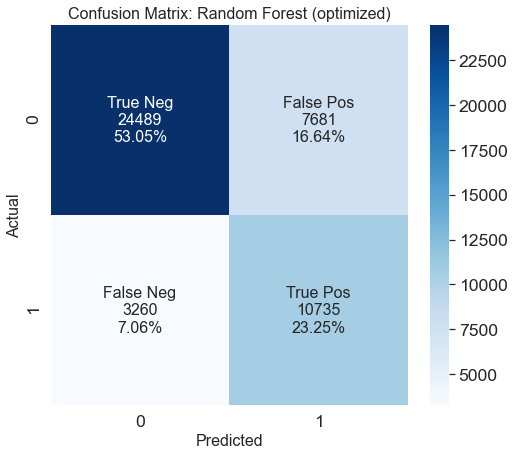

In [331]:
conf_matrix = np.array([[24489,  7681],[ 3260, 10735]])

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(8,7)) 
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues',annot_kws={"size": 16})
plt.title('Confusion Matrix: Random Forest (optimized)', fontsize = 16); # title with fontsize 20
plt.xlabel('Predicted', fontsize = 16);
plt.ylabel('Actual', fontsize = 16);
plt.savefig('plots/confusion_matrix_RF_optimized.png',dpi=300)

Undersampling
KNN


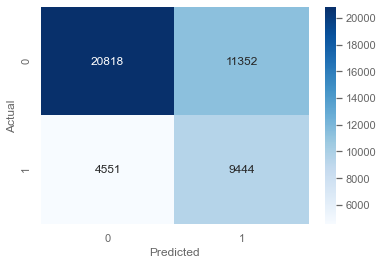


Confusion matrix on test
[[20818 11352]
 [ 4551  9444]]


SVC


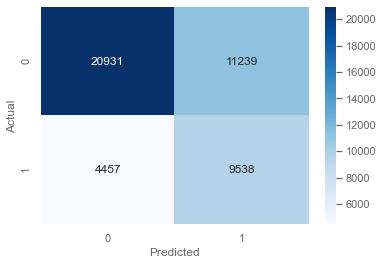


Confusion matrix on test
[[20931 11239]
 [ 4457  9538]]


logreg


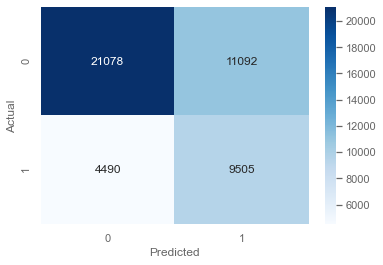


Confusion matrix on test
[[21078 11092]
 [ 4490  9505]]


decisiontree


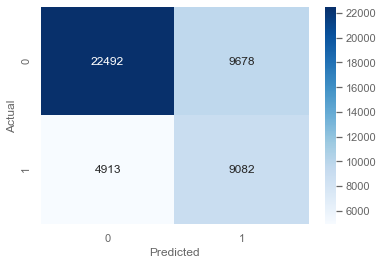


Confusion matrix on test
[[22492  9678]
 [ 4913  9082]]


randomforest


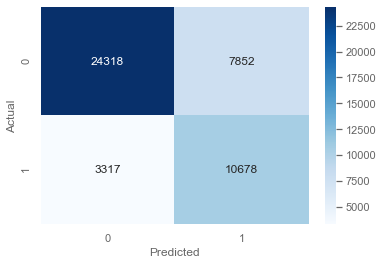


Confusion matrix on test
[[24318  7852]
 [ 3317 10678]]


XGBoost


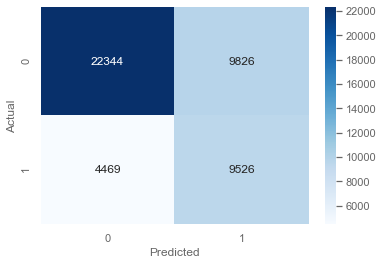


Confusion matrix on test
[[22344  9826]
 [ 4469  9526]]


adaBoost


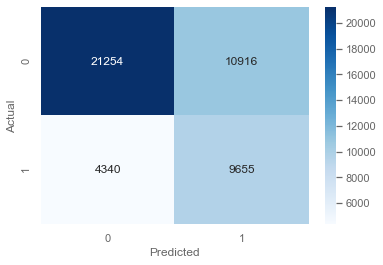


Confusion matrix on test
[[21254 10916]
 [ 4340  9655]]




In [305]:
Results_RF_presentation = pipeline(X,y,balance='under')

In [306]:
Results_RF_presentation.round(3)

,model,acc_train,acc_test,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test
0,KNN,0.653,0.656,0.657,0.543,0.666,0.675,0.649,0.454
0,SVC,0.668,0.660,0.674,0.549,0.685,0.682,0.662,0.459
0,logreg,0.669,0.662,0.673,0.550,0.682,0.679,0.664,0.461
0,decisiontree,0.674,0.684,0.664,0.555,0.645,0.649,0.686,0.484
0,randomforest,0.746,0.758,0.745,0.657,0.744,0.763,0.746,0.576
0,XGBoost,0.685,0.690,0.681,0.571,0.673,0.681,0.689,0.492
0,adaBoost,0.675,0.670,0.679,0.559,0.688,0.690,0.670,0.469


### Optimization of RandomForest - Recall - Gridsearch

In [214]:
def pipeline_optimization_part2(X,y,balance=None):
    
    # devide features
    categoric_features = list(X.columns[X.dtypes==object])

    numeric_features = list(X.columns[X.dtypes != object])

    # split train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state,stratify=y)
    
    if balance == 'over':
        # define oversampling strategy
        print('Oversampling')
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_train, y_train = oversample.fit_resample(X_train, y_train)

    if balance == 'under':
        print('Undersampling')
        # define undersample strategy
        undersample = RandomUnderSampler(sampling_strategy='majority')
        X_train, y_train = undersample.fit_resample(X_train, y_train)
        
    # Hyperparameter grid
    param_randomforest = {
    'randomforest__criterion' : ['gini', 'entropy'],
    'randomforest__n_estimators': [360,380,400,420,440], #np.linspace(10, 500,50).astype(int),
    'randomforest__max_depth': [32,35,37],
    'randomforest__max_features': ['auto'],
    'randomforest__bootstrap': [True],
    'randomforest__min_samples_leaf': [1, 2],
    'randomforest__min_samples_split': [3, 4, 5, 6, 7],
    }
    
    models={
        #'KNN' : KNeighborsClassifier(n_neighbors=5, metric='euclidean',n_jobs=-1),
        #'SVC' : LinearSVC(),
        #'logreg': LogisticRegression(random_state=random_state,n_jobs=-1), 
        #'decisiontree': DecisionTreeClassifier(random_state=random_state,max_depth=10),
        'randomforest': RandomForestClassifier(random_state=random_state, n_jobs=-1,n_estimators=300)
        #'XGBoost' : XGBClassifier(random_state=random_state, n_jobs=-1),
        #'adaBoost' : AdaBoostClassifier(random_state=random_state)
        }  
    
    # create preprocessors
    numeric_transformer = Pipeline(steps=[
        ('imputer_num', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
        #('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
            ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categoric_features)
        ])

    model_results = pd.DataFrame(columns=['model','acc_train','acc_test','f1_train','f1_test','recall_train','recall_test','precision_train','precision_test'])
    
    # process pipeline for every model
    for model in models.items():
        
        print(model[0])
        pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                               (model[0], model[1])
                               ])
        
        grid_randomforest = GridSearchCV(pipe, param_grid = param_randomforest, 
                              cv = 3, scoring='f1', n_jobs = -1, verbose = 5)
        # fit model
        grid_randomforest.fit(X_train, y_train)
        #pipe.fit(X_train, y_train)
        
        # Show best parameters
        print('Best score:\n{:.2f}'.format(grid_randomforest.best_score_))
        print("Best parameters:\n{}".format(grid_randomforest.best_params_))
        
        # Save best model as best_model
        best_model = grid_randomforest.best_estimator_
        
        #pipe_best = Pipeline(steps=[('preprocessor', preprocessor), 
        #                       (model[0], best_model)
        #                       ])
        
        # fit best pipe
        #pipe_best.fit(X_train, y_train)
        #predict results
        #y_train_pred = cross_val_predict(grid_randomforest,X_train,y_train,cv=5)
        y_train_pred = grid_randomforest.predict(X_train)
        #y_train_pred = cross_val_predict(pipe_best, X_train, y_train, cv=5)

        y_test_pred = grid_randomforest.predict(X_test)
        
        results = train_predict(model[0],y_train, y_test, y_train_pred, y_test_pred)
        
        model_results = pd.concat([model_results, pd.DataFrame(results,index=[0])])
        # print results
        #print("\nResults on training data: ")
        #print(classification_report(y_train, y_train_pred))
        #print("\nResults on test data:")
        #print(classification_report(y_test, y_test_pred))
        print("\nConfusion matrix on test")
        print(confusion_matrix(y_test, y_test_pred))
        print("\n")
    return model_results

In [201]:
RandomizedSearch_randomforst_part2 = pipeline_optimization_part2(X,y,balance='under')

Undersampling
randomforest
Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 21.9min finished


Best score:
0.74
Best parameters:
{'randomforest__bootstrap': True, 'randomforest__max_depth': None, 'randomforest__max_features': 'sqrt', 'randomforest__min_samples_leaf': 1, 'randomforest__min_samples_split': 5, 'randomforest__n_estimators': 600}

Confusion matrix on test
[[24421  7749]
 [ 3283 10712]]




Best score:
0.74

Best parameters:
{'randomforest__bootstrap': True, 'randomforest__max_depth': None, 'randomforest__max_features': 'sqrt', 'randomforest__min_samples_leaf': 1, 'randomforest__min_samples_split': 5, 'randomforest__n_estimators': 600}

Confusion matrix on test

[[24421  7749]
 
 [ 3283 10712]]

In [210]:
RandomizedSearch_randomforst_part2

,model,acc_train,acc_test,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test
0,randomforest,0.988972,0.761031,0.988988,0.660094,0.990401,0.765416,0.987579,0.58025


In [203]:
RandomizedSearch_randomforst_part2_criterion = pipeline_optimization_part2(X,y,balance='under')

Undersampling
randomforest
Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 29.5min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 55.8min finished


Best score:
0.74
Best parameters:
{'randomforest__bootstrap': True, 'randomforest__criterion': 'entropy', 'randomforest__max_depth': None, 'randomforest__max_features': 'sqrt', 'randomforest__min_samples_leaf': 1, 'randomforest__min_samples_split': 6, 'randomforest__n_estimators': 600}

Confusion matrix on test
[[24342  7828]
 [ 3280 10715]]




In [204]:
RandomizedSearch_randomforst_part2_criterion

,model,acc_train,acc_test,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test
0,randomforest,0.985602,0.759385,0.985623,0.658615,0.987091,0.765631,0.984161,0.577846


### Optimization of RandomForest - F1 - RandomSearch

In [207]:
RandomizedSearch_randomforst_f1 = pipeline_optimization(X,y,balance='under')

Undersampling
randomforest
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 56.2min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 111.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 122.1min finished


Best score:
0.73
Best parameters:
{'randomforest__n_estimators': 400, 'randomforest__min_samples_split': 5, 'randomforest__min_samples_leaf': 1, 'randomforest__max_features': 'auto', 'randomforest__max_depth': 35, 'randomforest__bootstrap': True}

Confusion matrix on test
[[24490  7680]
 [ 3305 10690]]




Best score:
0.73

Best parameters:
{'randomforest__n_estimators': 400, 'randomforest__min_samples_split': 5, 'randomforest__min_samples_leaf': 1, 'randomforest__max_features': 'auto', 'randomforest__max_depth': 35, 'randomforest__bootstrap': True}

Confusion matrix on test

[[24490  7680]
 
 [ 3305 10690]]

In [209]:
RandomizedSearch_randomforst_f1.round(3)

,model,acc_train,acc_test,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test
0,randomforest,0.988,0.762,0.988,0.661,0.989,0.764,0.987,0.582


### Optimization of RandomForest - F1 - GridSearch

In [215]:
RandomizedSearch_randomforst_f1_part2 = pipeline_optimization_part2(X,y,balance='under')

Undersampling
randomforest
Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 36.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 57.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 87.1min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 122.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 126.0min finished


Best score:
0.74
Best parameters:
{'randomforest__bootstrap': True, 'randomforest__criterion': 'entropy', 'randomforest__max_depth': 35, 'randomforest__max_features': 'auto', 'randomforest__min_samples_leaf': 1, 'randomforest__min_samples_split': 4, 'randomforest__n_estimators': 380}

Confusion matrix on test
[[24437  7733]
 [ 3266 10729]]




Best score:
0.74

Best parameters:
{'randomforest__bootstrap': True, 'randomforest__criterion': 'entropy', 'randomforest__max_depth': 35, 'randomforest__max_features': 'auto', 'randomforest__min_samples_leaf': 1, 'randomforest__min_samples_split': 4, 'randomforest__n_estimators': 380}

Confusion matrix on test

[[24437  7733]
 
 [ 3266 10729]]


In [216]:
RandomizedSearch_randomforst_f1_part2

,model,acc_train,acc_test,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test
0,randomforest,0.994558,0.761746,0.994556,0.661121,0.994355,0.766631,0.994758,0.58114


# Optimization - Top51 Features

In [4]:
# new feature dataframe
df_importance = pd.read_csv('data/df_clean_engineered_all.csv')

y = df_importance['churn']
df_importance = df_importance.drop(['churn','plz_3','abo_registrierung_min','nl_registrierung_min','ort'], axis = 1)

df_importance = pd.get_dummies(df_importance, columns = ['kanal', 'objekt_name', 'aboform_name', 'zahlung_rhythmus_name','zahlung_weg_name', 'plz_1', 'plz_2', 'land_iso_code', 'anrede','titel'], drop_first = True)

In [5]:
important_features_combined_dropping = ['zahlung_weg_name_Rechnung',
 'zahlung_rhythmus_name_halbjährlich',
 'rechnungsmonat',
 'received_anzahl_6m',
 'openedanzahl_6m',
 'objekt_name_ZEIT Digital',
 'nl_zeitbrief',
 'nl_aktivitaet',
 'liefer_beginn_evt',
 'cnt_umwandlungsstatus2_dkey',
 'clickrate_3m',
 'anrede_Frau',
 'aboform_name_Geschenkabo',
 'unsubscribed_anzahl_1m',
 'studentenabo',
 'received_anzahl_bestandskunden_6m',
 'openrate_produktnews_3m',
 'opened_anzahl_bestandskunden_6m',
 'objekt_name_DIE ZEIT - CHRIST & WELT',
 'nl_zeitshop',
 'nl_opt_in_sum',
 'nl_opened_1m',
 'kanal_andere',
 'kanal_B2B',
 'clicked_anzahl_6m',
 'che_reg',
 'MONTH_DELTA_nl_min',
 'zon_zp_red',
 'zahlung_rhythmus_name_vierteljährlich',
 'unsubscribed_anzahl_hamburg_1m',
 'unsubscribed_anzahl_6m',
 'sum_zon',
 'sum_reg',
 'shop_kauf',
 'plz_2_10',
 'plz_1_7',
 'plz_1_1',
 'openrate_zeitbrief_3m',
 'openrate_produktnews_1m',
 'openrate_3m',
 'openrate_1m',
 'nl_unsubscribed_6m',
 'nl_fdz_organisch',
 'metropole',
 'cnt_abo_magazin',
 'cnt_abo_diezeit_digital',
 'cnt_abo',
 'clicked_anzahl_bestandskunden_3m',
 'aboform_name_Probeabo',
 'aboform_name_Negative Option',
 'MONTH_DELTA_abo_min']

In [6]:
df_importance = df_importance[important_features_combined_dropping]

In [7]:
df_importance.shape

(184660, 51)

In [8]:
X = df_importance

Undersampling
KNN


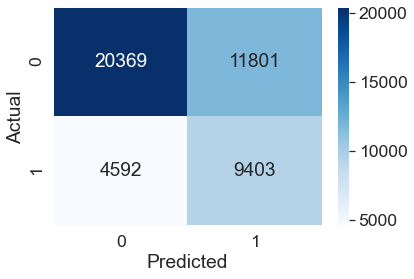


Confusion matrix on test
[[20369 11801]
 [ 4592  9403]]


SVC


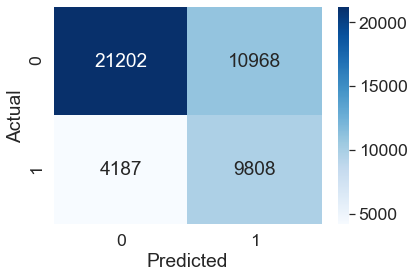


Confusion matrix on test
[[21202 10968]
 [ 4187  9808]]


logreg


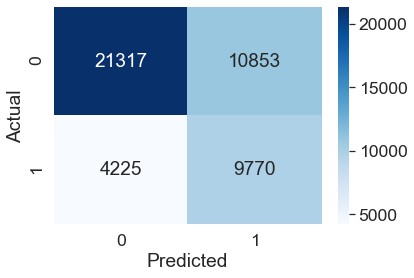


Confusion matrix on test
[[21317 10853]
 [ 4225  9770]]


decisiontree


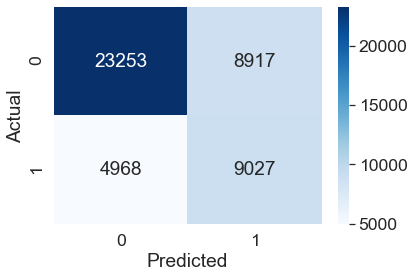


Confusion matrix on test
[[23253  8917]
 [ 4968  9027]]


randomforest


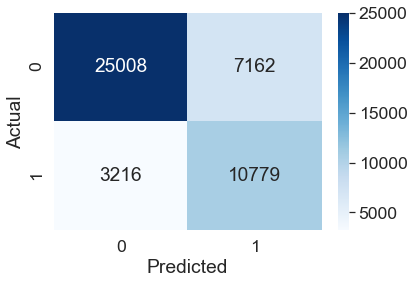


Confusion matrix on test
[[25008  7162]
 [ 3216 10779]]


XGBoost


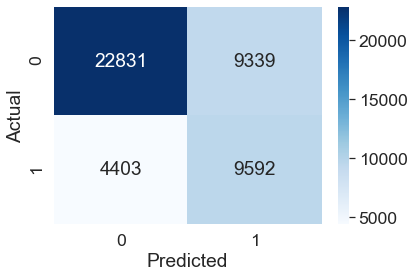


Confusion matrix on test
[[22831  9339]
 [ 4403  9592]]


adaBoost


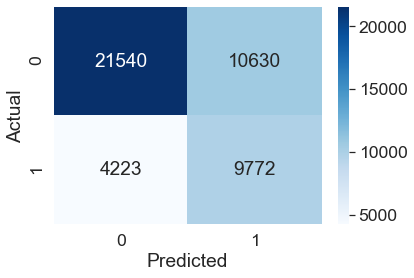


Confusion matrix on test
[[21540 10630]
 [ 4223  9772]]




In [339]:
feature_selection_top100 = pipeline(X,y,balance='under')

In [341]:
feature_selection_top100.round(3)

,model,acc_train,acc_test,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test
0,KNN,0.644,0.645,0.650,0.534,0.661,0.672,0.639,0.443
0,SVC,0.679,0.672,0.685,0.564,0.699,0.701,0.672,0.472
0,logreg,0.679,0.673,0.684,0.564,0.695,0.698,0.673,0.474
0,decisiontree,0.680,0.699,0.672,0.565,0.655,0.645,0.689,0.503
0,randomforest,0.758,0.775,0.756,0.675,0.750,0.770,0.763,0.601
0,XGBoost,0.695,0.702,0.692,0.583,0.685,0.685,0.699,0.507
0,adaBoost,0.682,0.678,0.686,0.568,0.695,0.698,0.677,0.479


## Optimization of RandomForest

### Optimization of RandomForest - Precision - RandomSearch

In [9]:
feature_selection_top100_precision_randomsearch = pipeline_optimization(X,y,balance='under')

Undersampling
randomforest
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed: 73.5min finished


Best score:
0.76
Best parameters:
{'randomforest__n_estimators': 2000, 'randomforest__min_samples_split': 4, 'randomforest__min_samples_leaf': 2, 'randomforest__max_features': 'sqrt', 'randomforest__max_depth': None, 'randomforest__criterion': 'entropy', 'randomforest__bootstrap': False}

Confusion matrix on test
[[25224  6946]
 [ 3259 10736]]




Best score:
0.76
Best parameters:

{'randomforest__n_estimators': 2000, 'randomforest__min_samples_split': 4, 'randomforest__min_samples_leaf': 2, 'randomforest__max_features': 'sqrt', 'randomforest__max_depth': None, 'randomforest__criterion': 'entropy', 'randomforest__bootstrap': False}

Confusion matrix on test

[[25224  6946]

 [ 3259 10736]]

In [10]:
feature_selection_top100_precision_randomsearch

,model,acc_train,acc_test,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test
0,randomforest,0.994629,0.778945,0.994624,0.677842,0.993641,0.767131,0.995609,0.607171


### Optimization of RandomForest - Precision - GridSearch

In [18]:
def pipeline_optimization_Gridsearch(X,y,balance=None):
    
    # devide features
    categoric_features = list(X.columns[X.dtypes==object])

    numeric_features = list(X.columns[X.dtypes != object])

    # split train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state,stratify=y)
    
    if balance == 'over':
        # define oversampling strategy
        print('Oversampling')
        oversample = RandomOverSampler(sampling_strategy='minority')
        X_train, y_train = oversample.fit_resample(X_train, y_train)

    if balance == 'under':
        print('Undersampling')
        # define undersample strategy
        undersample = RandomUnderSampler(sampling_strategy='majority')
        X_train, y_train = undersample.fit_resample(X_train, y_train)
        
    # Hyperparameter grid
    param_randomforest = {
    'randomforest__criterion': ['entropy'], #np.linspace(10, 500,50).astype(int),
    'randomforest__n_estimators': [1800, 2000, 2200, 2500], #np.linspace(10, 500,50).astype(int),
    'randomforest__max_depth': [None],
    'randomforest__max_features': ['sqrt'],
    'randomforest__bootstrap': [False],
    'randomforest__min_samples_leaf': [2, 3, 4],
    'randomforest__min_samples_split': [3, 4, 5],
    }
    
    models={
        #'KNN' : KNeighborsClassifier(n_neighbors=5, metric='euclidean',n_jobs=-1),
        #'SVC' : LinearSVC(),
        #'logreg': LogisticRegression(random_state=random_state,n_jobs=-1), 
        #'decisiontree': DecisionTreeClassifier(random_state=random_state,max_depth=10),
        'randomforest': RandomForestClassifier(random_state=random_state, n_jobs=-1)
        #'XGBoost' : XGBClassifier(random_state=random_state, n_jobs=-1),
        #'adaBoost' : AdaBoostClassifier(random_state=random_state)
        }  
    
    # create preprocessors
    numeric_transformer = Pipeline(steps=[
        ('imputer_num', SimpleImputer(strategy='median')),
        ('scaler', MinMaxScaler())
        #('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
            ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categoric_features)
        ])

    model_results = pd.DataFrame(columns=['model','acc_train','acc_test','f1_train','f1_test','recall_train','recall_test','precision_train','precision_test'])
    
    # process pipeline for every model
    for model in models.items():
        
        print(model[0])
        pipe = Pipeline(steps=[('preprocessor', preprocessor), 
                               (model[0], model[1])
                               ])

        grid_randomforest = GridSearchCV(pipe, param_randomforest, cv=3, scoring='precision',
                           verbose=5, n_jobs=-1)
        
        # fit model
        grid_randomforest.fit(X_train, y_train)
        #pipe.fit(X_train, y_train)
        
        # Show best parameters
        print('Best score:\n{:.2f}'.format(grid_randomforest.best_score_))
        print("Best parameters:\n{}".format(grid_randomforest.best_params_))
        
        # Save best model as best_model
        best_model = grid_randomforest.best_estimator_
        
        #pipe_best = Pipeline(steps=[('preprocessor', preprocessor), 
        #                       (model[0], best_model)
        #                       ])
        
        # fit best pipe
        #pipe_best.fit(X_train, y_train)
        #predict results
        #y_train_pred = cross_val_predict(grid_randomforest,X_train,y_train,cv=5)
        y_train_pred = grid_randomforest.predict(X_train)
        #y_train_pred = cross_val_predict(pipe_best, X_train, y_train, cv=5)

        y_test_pred = grid_randomforest.predict(X_test)
        
        results = train_predict(model[0],y_train, y_test, y_train_pred, y_test_pred)
        
        model_results = pd.concat([model_results, pd.DataFrame(results,index=[0])])
        # print results
        #print("\nResults on training data: ")
        #print(classification_report(y_train, y_train_pred))
        #print("\nResults on test data:")
        #print(classification_report(y_test, y_test_pred))
        print("\nConfusion matrix on test")
        print(confusion_matrix(y_test, y_test_pred))
        print("\n")
    return model_results

In [19]:
feature_selection_top100_precision_gridsearch = pipeline_optimization_Gridsearch(X,y,balance='under')

Undersampling
randomforest
Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 74.5min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 129.8min finished


Best score:
0.76
Best parameters:
{'randomforest__bootstrap': False, 'randomforest__criterion': 'entropy', 'randomforest__max_depth': None, 'randomforest__max_features': 'sqrt', 'randomforest__min_samples_leaf': 2, 'randomforest__min_samples_split': 5, 'randomforest__n_estimators': 2000}

Confusion matrix on test
[[25248  6922]
 [ 3234 10761]]




In [20]:
feature_selection_top100_precision_gridsearch

,model,acc_train,acc_test,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test
0,randomforest,0.994355,0.780006,0.994351,0.679399,0.993688,0.768917,0.995015,0.608551
